In [ ]:
!rm -rf .models
!mkdir .models
!wget -q -O .models/cifar_nat.pt "https://www.dropbox.com/s/yhpp4yws7sgi6lj/cifar_nat.pt?dl=1"
!wget -q -O .models/cifar_linf_8.pt "https://www.dropbox.com/s/yhpp4yws7sgi6lj/cifar_linf_8.pt?dl=1"

In [1]:
import os
import pathlib
import random
import functools
import copy
import sys
import pickle
import tarfile
import operator
import math
import requests
import importlib
os.environ["NOTEBOOK_MODE"] = "1"

import tqdm
import cox

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import sklearn
from sklearn import preprocessing
import scipy

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

import torch

import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)

import flax
import neural_tangents as nt
import art
import robustness
from robustness import model_utils, datasets, train, defaults

import vit_jax

import adversarial_ntks as atk

f:\users\0\main\active\erlija\adversarial-ntks\robustness\robustness\train.py:24: UserWarning: Could not import amp.
  warnings.warn('Could not import amp.')


ValueError: bad marshal data (unknown type code)

In [2]:
CIFAR10 = {}

In [3]:
CIFAR10.update({
    "dataset": robustness.datasets.CIFAR(".data"),
    "workers": 12,
    "arch": "resnet50",
    "resume_path_nat": ".models/cifar_nat.pt",
    "resume_path_linf": ".models/cifar_linf_8.pt",
    "labels": ["airplane", "automobile", "bird", "cat", "deer",
        "dog", "frog", "horse", "ship", "truck"],
    
    "train_subset": 1,
    "test_subset": 2048,
    "batch_size": 64,
    
    "perturb_target": 3,
    "perturb_eps": 0.08,
    "attack_lr_scaling": 2.5,
    "attack_steps": 20,

    "display_samples": 10,
    "display_sample_img_size": 3})

In [4]:
def exp_make_loaders(exp):
    exp["train_loader"], exp["val_loader"] = exp["dataset"].make_loaders(
        batch_size=exp["batch_size"],
        subset=exp["train_subset"],
        test_subset=exp["test_subset"],
        workers=exp["workers"])

exp_make_loaders(CIFAR10)

==> Preparing dataset cifar..
Files already downloaded and verified
Files already downloaded and verified


In [5]:
def exp_load_saved(exp):
    exp["model_nat"], _ = model_utils.make_and_restore_model(
        arch=exp["arch"],
        resume_path=exp["resume_path_nat"],
        dataset=exp["dataset"])
    exp["model_linf"], _ = model_utils.make_and_restore_model(
        arch=exp["arch"],
        resume_path=exp["resume_path_linf"],
        dataset=exp["dataset"])

exp_load_saved(CIFAR10)

=> loading checkpoint '.models/cifar_nat.pt'
=> loaded checkpoint '.models/cifar_nat.pt' (epoch 190)
=> loading checkpoint '.models/cifar_linf_8.pt'
=> loaded checkpoint '.models/cifar_linf_8.pt' (epoch 190)


In [6]:
def exp_eval_ueb_model(exp, model_id, samples):
    exp[model_id].eval()
    hist_dat = []
    with torch.no_grad():
        for batch in tqdm.tqdm(exp["val_loader"]):
            total_c_batch = np.zeros(batch[1].shape)
            for sample in range(samples):
                # Uniform perturbance.
                in_cpu = batch[0] + \
                    torch.rand(*batch[0].shape) * exp["perturb_eps"] * 2 - \
                    exp["perturb_eps"]

                out = exp[model_id](in_cpu.cuda())
                out_cpu = (out[0].cpu(), out[1].cpu())
                pred_classes = np.array([probs.argmax().item()
                    for probs in out_cpu[0]])
                correctness = np.equal(
                    pred_classes, np.array(batch[1].tolist()))
                total_c_batch += correctness
            hist_dat.append(1 - total_c_batch / samples)
    return np.concatenate(hist_dat)

CIFAR10["data_nat"] = exp_eval_ueb_model(CIFAR10, "model_nat", 512)

100%|██████████| 32/32 [1:19:40<00:00, 149.39s/it]


<ipython-input-7-cd157576e0ca>:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


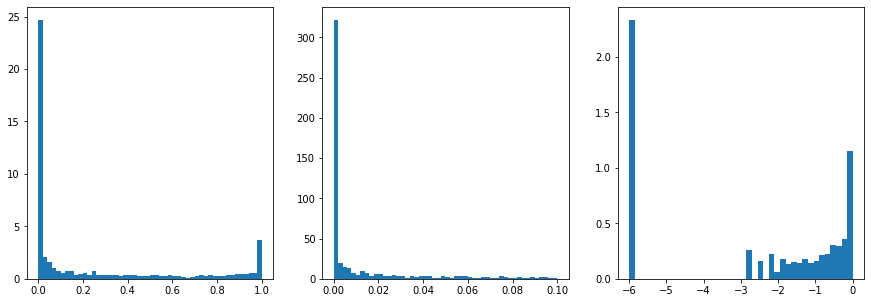

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].hist(CIFAR10["data_nat"], bins=50, density=True)
ax[1].hist(CIFAR10["data_nat"], bins=50, density=True, range=(0, 0.1))
ax[2].hist(np.log10(0.000001 + CIFAR10["data_nat"]), bins=40, density=True)
fig.show()

In [8]:
np.count_nonzero(CIFAR10["data_nat"]) / len(CIFAR10["data_nat"])

0.64990234375

100%|██████████| 32/32 [1:19:45<00:00, 149.54s/it]
<ipython-input-9-e940be873753>:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


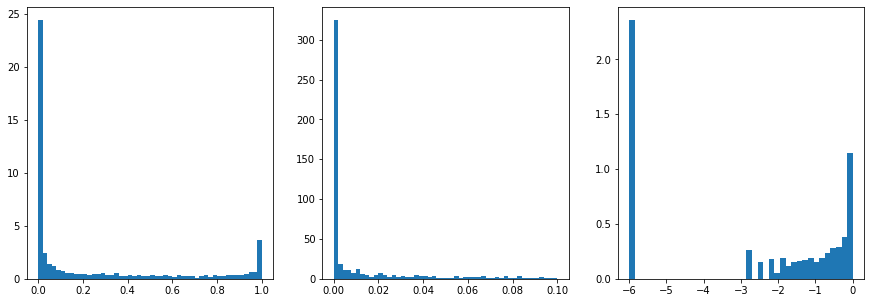

In [9]:
CIFAR10["data_linf"] = exp_eval_ueb_model(CIFAR10, "model_linf", 512)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].hist(CIFAR10["data_linf"], bins=50, density=True)
ax[1].hist(CIFAR10["data_linf"], bins=50, density=True, range=(0, 0.1))
ax[2].hist(np.log10(0.000001 + CIFAR10["data_linf"]), bins=40, density=True)
fig.show()

In [10]:
np.count_nonzero(CIFAR10["data_linf"]) / len(CIFAR10["data_linf"])

0.64599609375